In [11]:
!pip install casadi
!pip install matplotlib
import os
from IPython.display import clear_output

import numpy as np
import casadi
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches

import os
os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib
    import japanize_matplotlib

clear_output()

ModuleNotFoundError: No module named 'distutils'

# シンボリック

In [ ]:
x = casadi.SX.sym('x')
x

SX(x)

In [ ]:
z = casadi.SX.sym('Z',4,2)
print(z)


[[Z_0, Z_4], 
 [Z_1, Z_5], 
 [Z_2, Z_6], 
 [Z_3, Z_7]]


In [ ]:
print(casadi.sqrt(x**2 + 10))

sqrt((sq(x)+10))


## DM

In [ ]:
C = casadi.DM(2,3)
print(C)


[[00, 00, 00], 
 [00, 00, 00]]


In [ ]:
D_array = np.array([
    [1.,2.,3.],
    [4.,5.,6.]
])

D = casadi.DM(D_array)

D_array2 = D.full()

print(np.array_equal(D_array,D_array2))

True


In [ ]:
D = casadi.diag([1,2,3])
print(D)


[[1, 00, 00], 
 [00, 2, 00], 
 [00, 00, 3]]


In [ ]:
D = casadi.diag([2,3,4,5])
M = casadi.SX(D)
print(D)


[[2, 00, 00, 00], 
 [00, 3, 00, 00], 
 [00, 00, 4, 00], 
 [00, 00, 00, 5]]


In [ ]:
print(M[:2,:3])


[[2, 00, 00], 
 [00, 3, 00]]


In [ ]:
M[0,:] = 2
M[3,0] = casadi.SX.sym("x")
print(M)

@1=2, 
[[@1, @1, @1, @1], 
 [00, 3, 00, 00], 
 [00, 00, 4, 00], 
 [x, 00, 00, 5]]


In [ ]:
x = casadi.SX.sym('x')
y = casadi.SX.sym('y',2,2)
print(casadi.sin(y)-x)


[[(sin(y_0)-x), (sin(y_2)-x)], 
 [(sin(y_1)-x), (sin(y_3)-x)]]


In [ ]:
print(y*y)
print(y@y)


[[sq(y_0), sq(y_2)], 
 [sq(y_1), sq(y_3)]]

[[(sq(y_0)+(y_2*y_1)), ((y_0*y_2)+(y_2*y_3))], 
 [((y_1*y_0)+(y_3*y_1)), ((y_1*y_2)+sq(y_3))]]


In [ ]:
print(y)
print(y.T)


[[y_0, y_2], 
 [y_1, y_3]]

[[y_0, y_1], 
 [y_2, y_3]]


In [ ]:
x = casadi.SX.eye(4)
print(x.reshape((2,8)))

@1=1, 
[[@1, 00, 00, 00, 00, @1, 00, 00], 
 [00, 00, @1, 00, 00, 00, 00, @1]]


In [ ]:
x = casadi.SX.sym('x',5)
y = casadi.SX.sym('y',5)
print(casadi.vertcat(x,y))

[x_0, x_1, x_2, x_3, x_4, y_0, y_1, y_2, y_3, y_4]


In [ ]:
x = casadi.SX.sym('x',3)
y = casadi.DM([1,2,3])
z = x - y
casadi.dot(z,z)

SX(((sq((x_0-1))+sq((x_1-2)))+sq((x_2-3))))

In [ ]:
x = casadi.SX.sym('x',1)
df = casadi.jacobian(x**2, x)
print(df)
print(casadi.simplify(df))

(x+x)
(2*x)


In [ ]:
A = casadi.SX.sym('A',3,2)
x = casadi.SX.sym('x',2)
print(A)
print(casadi.jacobian(A@x,x))


[[A_0, A_3], 
 [A_1, A_4], 
 [A_2, A_5]]

[[A_0, A_3], 
 [A_1, A_4], 
 [A_2, A_5]]


In [ ]:
[H,g] = casadi.hessian(casadi.dot(x,x),x)
print('H:', H)

H: @1=2, 
[[@1, 00], 
 [00, @1]]


# Function

In [ ]:
x = casadi.SX.sym('x')
y = casadi.SX.sym('y')
f1 = x
f2 = casadi.sin(y)*x
f = casadi.Function('f',[x,y],\
           [f1,f2],\
            ["x","y"],["f1","f2"])
print(f)

f:(x,y)->(f1,f2) SXFunction


In [ ]:
print(f(x=1.1,y=2.1))

{'f1': DM(1.1), 'f2': DM(0.94953)}


In [ ]:
x = casadi.SX.sym('x',4)
y = casadi.SX.sym("y",1)
f1 = 2*x+y
f = casadi.Function('f',\
    [x,y],[f1],["x","y"],["f1"])
print(f)

f:(x[4],y)->(f1[4]) SXFunction


In [ ]:
print(f())
print(f(x=casadi.DM([1])))
print(f(x=casadi.DM([1,2,3,4])))
print(f(x=casadi.DM([1,2,3,4]),y=1))

{'f1': DM([0, 0, 0, 0])}
{'f1': DM([2, 2, 2, 2])}
{'f1': DM([2, 4, 6, 8])}
{'f1': DM([3, 5, 7, 9])}


# 数理最適化

## NLP

In [26]:
x = casadi.SX.sym('x')
y = casadi.SX.sym('y')
nlp = {'x':casadi.vertcat(x,y), \
        'f':x**3 - y**2,\
        'g':y**2 - x**3 }
S = casadi.nlpsol('S', 'ipopt', nlp)
print(S)

S:(x0[2],p[],lbx[2],ubx[2],lbg,ubg,lam_x0[2],lam_g0)->(x[2],f,g,lam_x[2],lam_g,lam_p[]) IpoptInterface


In [27]:
r = S(x0=[0, 1],\
      lbg=0, ubg=0)
x_opt = np.array(r['x'])
print('x_opt: ', x_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

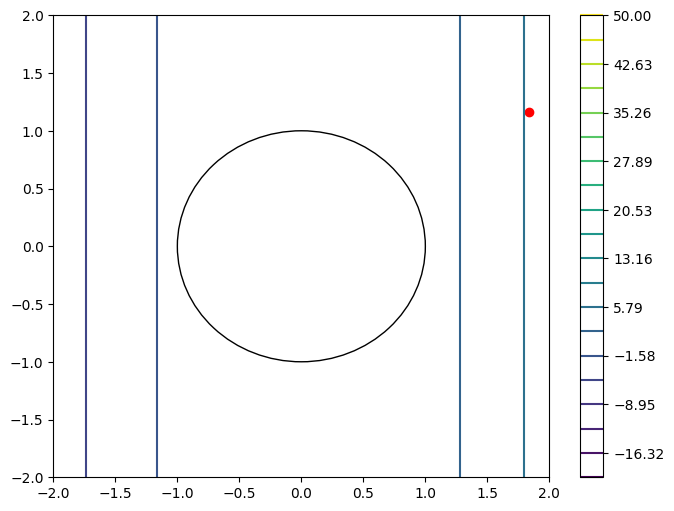

In [39]:
X_, Y_ = np.arange(-2,2.01,0.01), np.arange(-2,2.01,0.01)
X, Y = np.meshgrid(X_, Y_)
Z = X**3 

levs = np.linspace(-20,50,20)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x_opt[0], x_opt[1], c="red")
cs = ax.contour(X,Y,Z,levels=levs)
ax.add_patch(plt.Circle( xy=(0, 0), radius=1, fill=False))
fig.colorbar(cs)

plt.savefig("images/chap3_NLP_2D.png")
plt.show()

## NLP example

In [29]:
a = 10

R = casadi.SX.sym("R")
x_list = [casadi.SX.sym(f"x_{i}") for i in range(5)]
y_list = [casadi.SX.sym(f"y_{i}") for i in range(5)]
r_list = [R,R,R,2*R,2*R]

x_nlp = casadi.vertcat(R,*x_list,*y_list)
f_nlp = -R
g_nlp = []

g_nlp.append(R)

for i in range(5):
       g_nlp.append(x_list[i]-r_list[i])
       g_nlp.append(a-x_list[i]-r_list[i])
       g_nlp.append(y_list[i]-r_list[i])
       g_nlp.append(a-y_list[i]-r_list[i])

for j in range(5):
       for i in range(0,j):
              eq = (x_list[i]-x_list[j])**2 + (y_list[i]-y_list[j])**2 - (r_list[i]+r_list[j])**2
              g_nlp.append(eq)

g_nlp = casadi.vertcat(*g_nlp)

nlp = {"x":x_nlp,"f":f_nlp,"g":g_nlp}

S = casadi.nlpsol('S', 'ipopt', nlp)
print(S)

S:(x0[11],p[],lbx[11],ubx[11],lbg[31],ubg[31],lam_x0[11],lam_g0[31])->(x[11],f,g[31],lam_x[11],lam_g[31],lam_p[]) IpoptInterface


In [30]:
r = S(x0=[1,1,3,8,7,3,1,2,8,3,7],\
      lbg=[0]*31, ubg=[np.inf]*31)
x_opt = np.array(r['x']).ravel()
print('x_opt: ', x_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       91
Number of nonzeros in Lagrangian Hessian.............:       31

Total number of variables............................:       11
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       31
        inequality constraints with only lower bounds:       31
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e+00 0.00e+00 1.56e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

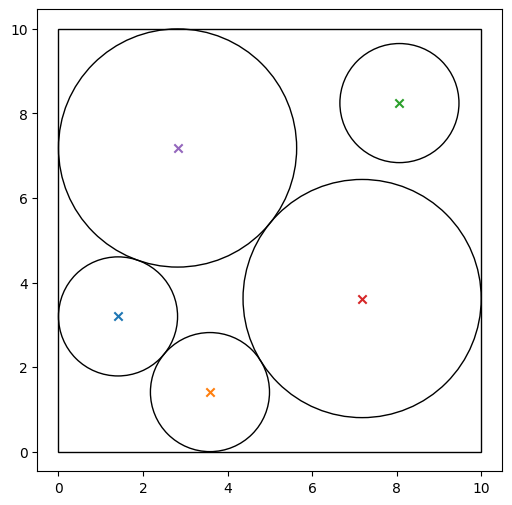

In [31]:
R_opt = x_opt[0]
coord_opt = x_opt[1:].reshape(2,5).T

fig, ax = plt.subplots(figsize=(6,6))

for i in range(5):
       radius = R_opt if i <= 2 else 2*R_opt
       circle = patches.Circle(xy=coord_opt[i],radius=radius,fill=False)
       ax.add_patch(circle)
       ax.scatter(*coord_opt[i],marker="x")

rect = patches.Rectangle([0,0],10,10,fill=False)
ax.add_patch(rect)

ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.axis("equal")

plt.savefig("images/chap3_NLP_packing_1.png")
plt.show()

In [32]:
r = S(x0=[1,1,3,8,7,3,1,3,8,3,7],\
      lbg=[0]*31, ubg=[np.inf]*31)
x_opt = np.array(r['x']).ravel()
print('x_opt: ', x_opt)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       91
Number of nonzeros in Lagrangian Hessian.............:       31

Total number of variables............................:       11
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       31
        inequality constraints with only lower bounds:       31
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e+00 0.00e+00 1.52e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

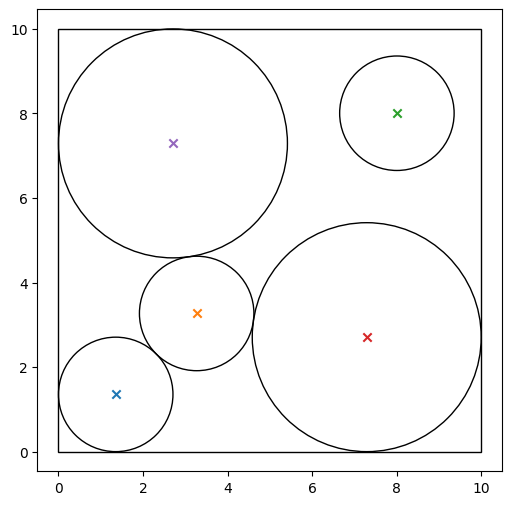

In [33]:
R_opt = x_opt[0]
coord_opt = x_opt[1:].reshape(2,5).T

fig, ax = plt.subplots(figsize=(6,6))

for i in range(5):
       radius = R_opt if i <= 2 else 2*R_opt
       circle = patches.Circle(xy=coord_opt[i],radius=radius,fill=False)
       ax.add_patch(circle)
       ax.scatter(*coord_opt[i],marker="x")

rect = patches.Rectangle([0,0],10,10,fill=False)
ax.add_patch(rect)

ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.axis("equal")

plt.savefig("images/chap3_NLP_packing_2.png")
plt.show()

## QP

In [34]:
x = casadi.SX.sym('x')
y = casadi.SX.sym('y')
qp = {'x':casadi.vertcat(x,y), \
        'f':x**2 + 2*y**2 - x - 2*y,\
        'g':casadi.vertcat(
            x+y-3,
            x-1,
            3-y,
            -x+3*y+1,
            5-x-y
        )}
S = casadi.qpsol('S', 'osqp', qp)
print(S)

-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 7
          nnz(P) + nnz(A) = 12
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, 
S:(x0[2],p[],lbx[2],ubx[2],lbg[5],ubg[5],lam_x0[2],lam_g0[5])->(x[2],f,g[5],lam_x[2],lam_g[5],lam_p[]) MXFunction


In [35]:
r = S(x0=[0, 1],\
      lbg=[0,0,0,0,0], ubg=[0,np.inf,np.inf,np.inf,np.inf])
x_opt = np.array(r['x'])
print('x_opt: ', x_opt)

-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 7
          nnz(P) + nnz(A) = 12
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, 
iter   objective    pri res    dua res    rho
   1  -6.7634e-01   2.00e+00   4.00e+02   1.00e-01
  25   1.9162e+00   1.85e-04   1.02e-03   1.00e-01

status:               solved
number of iterations: 25
optimal objective:    1.9162
optimal rho estim

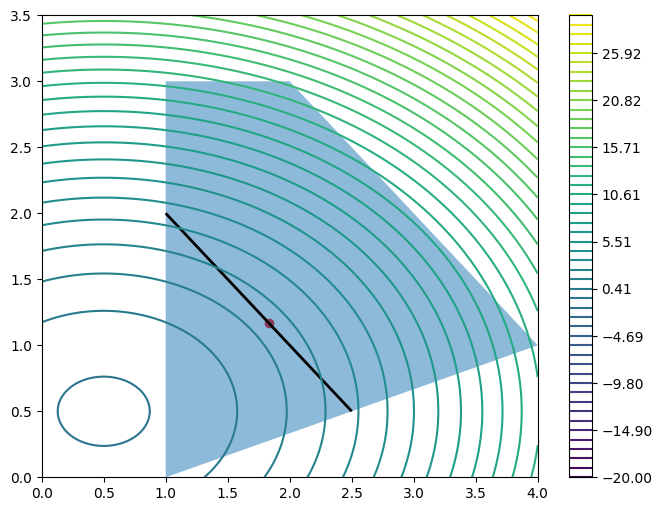

In [36]:
X_, Y_ = np.arange(0,4.01,0.01), np.arange(0,3.51,0.01)
X, Y = np.meshgrid(X_, Y_)
Z = X**2 + 2*Y**2 - X - 2*Y

levs = np.linspace(-20,30,50)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x_opt[0], x_opt[1], c="red")
cs = ax.contour(X,Y,Z,levels=levs)
fig.colorbar(cs)

points = [[1,0], [1,2], [1,3], [2,3], [4,1], [5/2,1/2]]
polygon = patches.Polygon(xy=points, closed=True,alpha=0.5)
ax.add_patch(polygon)

polyline = patches.Polygon([[1,2], [5/2,1/2]], closed=False, edgecolor='black', facecolor='none', linewidth=2)
ax.add_patch(polyline)

plt.savefig("images/chap3_QP_2D.png")
plt.show()

# option

In [37]:
x = casadi.SX.sym("x")
S = casadi.nlpsol("S","ipopt",{"x":x,"f":x})

S.print_options()

"Option name" [type] = value
> "error_on_fail"          [OT_BOOL]      "Throw exceptions when function evaluation fails (default true)."
> "print_time"          [OT_BOOL]      "print information about execution time. Implies record_time."
> "record_time"          [OT_BOOL]      "record information about execution time, for retrieval with stats()."
> "regularity_check"          [OT_BOOL]      "Throw exceptions when NaN or Inf appears during evaluation"
> "verbose"          [OT_BOOL]      "Verbose evaluation -- for debugging"
> "ad_weight"          [OT_DOUBLE]      "Weighting factor for derivative calculation.When there is an option of either using forward or reverse mode directional derivatives, the condition ad_weight*nf<=(1-ad_weight)*na is used where nf and na are estimates of the number of forward/reverse mode directional derivatives needed. By default, ad_weight is calculated automatically, but this can be overridden by setting this option. In particular, 0 means forcing forward mo

# ODE

/tmp/ipykernel_1836347/2588436872.py:34: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.savefig("images/chap3_integ.png")
/tmp/ipykernel_1836347/2588436872.py:34: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  plt.savefig("images/chap3_integ.png")
/tmp/ipykernel_1836347/2588436872.py:34: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  plt.savefig("images/chap3_integ.png")
/tmp/ipykernel_1836347/2588436872.py:34: UserWarning: Glyph 26512 (\N{CJK UNIFIED IDEOGRAPH-6790}) missing from font(s) DejaVu Sans.
  plt.savefig("images/chap3_integ.png")
/home/motoya-teranishi/workspace/control/CasADi_book/casadi_mpc_nyuumon_teranishi/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/motoya-teranishi/wo

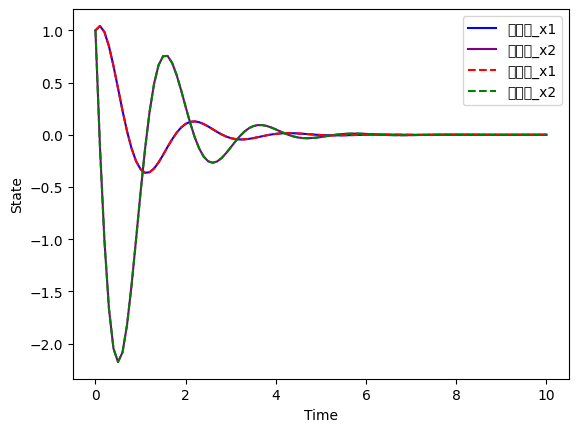

In [38]:
dt = 0.1
t_eval = np.arange(0, 10+dt, dt)
X = [casadi.DM([1,1])]

A = casadi.DM([
    [0,1],
    [-10,-2]
])
x = casadi.SX.sym('x',2)

ode = A@x
dae = {"x":x, "ode":ode}

F = casadi.integrator('F','idas',dae,0,dt)

for t in t_eval[:-1]:
    res = F(x0=X[-1])
    X.append(res["xf"])

X = np.array(X).reshape(-1,2)

X_true_1 = casadi.exp(-t_eval)*casadi.cos(3*t_eval)+2/3*casadi.exp(-t_eval)*casadi.sin(3*t_eval)
X_true_1 = X_true_1.full().ravel()
X_true_2 = casadi.exp(-t_eval)*casadi.cos(3*t_eval)-11/3*casadi.exp(-t_eval)*casadi.sin(3*t_eval)
X_true_2 = X_true_2.full().ravel()

plt.plot(t_eval, X[:,0], label="数値解_x1", color="blue")
plt.plot(t_eval, X[:,1], label="数値解_x2", color="purple")
plt.plot(t_eval, X_true_1, label="解析解_x1", color="red",linestyle="--")
plt.plot(t_eval, X_true_2, label="解析解_x2", color="green",linestyle="--")
plt.legend()
plt.xlabel("Time")
plt.ylabel("State")
plt.savefig("images/chap3_integ.png")
plt.show()